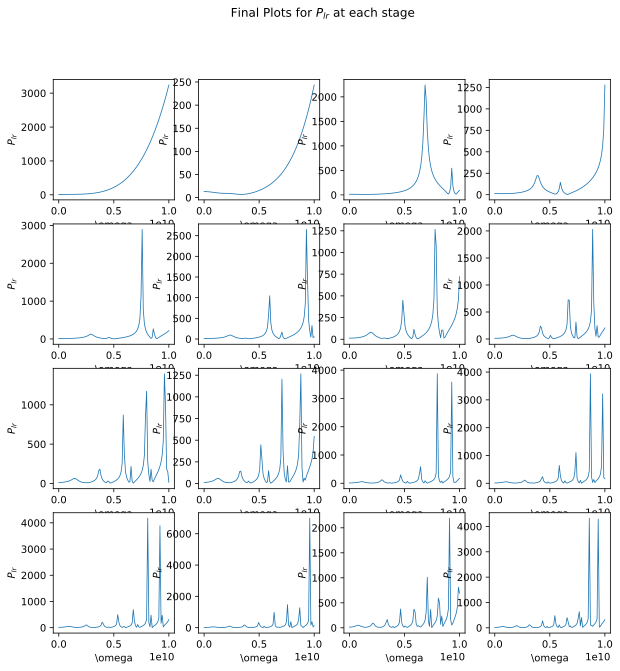

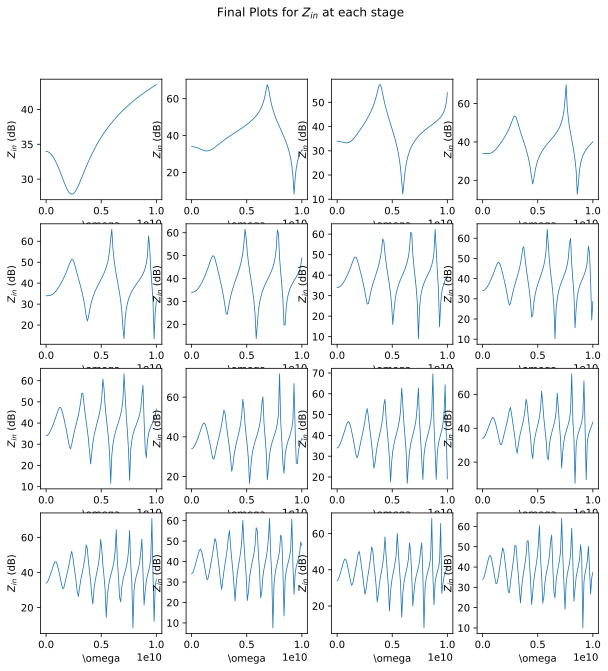

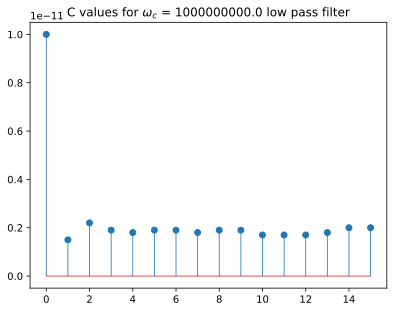

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8


# ----------- Actual Line fixed parameters ------------
wc = (1)*1e9
R0 = 50
L0 = 8e-9 # [nH/m]

# ----------- Line parameters for prototype low pass filter --------------

N = 16
L = L0
Rs = R0
RL = R0

# ----------- Test Matrices for w and C ----------

wstart = 100
wstop = 10e9
wpoints = 100
w = np.linspace(wstart, wstop, wpoints)

Cstart = 1e-13
Cstop = 1e-11
Cpoints = 100

C = np.linspace(Cstart, Cstop, Cpoints)

# --------- Storage Matrices -----------------

C_sel = np.zeros((N, 2))
Zin_sel = np.zeros((N, len(w)), dtype=np.complex256)
Plr_sel = np.zeros((N, len(w)), dtype=np.complex256)

# ----------- Comparison matrix -------------
Plr_req = 1 + (w/wc) ** 4

# ----------- Helpers ------------

def select_best_C(Plr, Plr_req):
    diff = abs(Plr-Plr_req)
    row_means = np.mean(diff, axis=1)
    min_mean_row_number = np.argmin(row_means)
    return min_mean_row_number, min(row_means)

def plot_plr_for_different_Cs(Plr, Plr_req, w, C, i, gridSize, ax):
    rows = len(Plr[:, 0])
    legend_str = []  # Create an empty list to store legend entries
    ax.set_title(f'$P_{{lr}}$ - Iteration {i+1}')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel("$P_{lr}$")
    for j in range(rows):
        ax.plot(w, abs(Plr[j, :]))
    for j in range(rows):
        legend_str.append(str(C[j]))
    ax.plot(w, Plr_req, 'x')
    #ax.legend(legend_str)

def plot_final_Plrs(Plr_sel, w, ax):
    rows = len(Plr_sel[:, 0])
    for j in range(rows):
        ax.flat[j].plot(w, abs(Plr_sel[j, :]))
        ax.flat[j].set_xlabel("\omega")
        ax.flat[j].set_ylabel("$P_{lr}$")
    
def plot_Zin_sel(Zin_sel, w, ax):
    rows = len(Plr_sel[:, 0])
    for j in range(rows):
        ax.flat[j].plot(w, 20*np.log10(abs(Zin_sel[j, :])))
        ax.flat[j].set_xlabel("\omega")
        ax.flat[j].set_ylabel("$Z_{in}$ (dB)")



# ----------- Start iterations ------------

Zin_prev = RL*np.ones(wpoints)
# Create a square grid of subplots
gridSize = int(np.ceil(np.sqrt(N)))

fig_Plrs, axes = plt.subplots(gridSize, gridSize, figsize=(10, 10))

for i in range(0, N):
    Zin_curr = 2j*L*w + (Zin_prev)/(1 + 1j*np.outer(C, np.multiply(w, Zin_prev)))
    #print("Zin_curr")
    #print(Zin_curr)
    Plr = 1 + (1 / (4 * Zin_prev)) * (
                (1 - Zin_prev) ** 2 + ( (Zin_prev**2 * (C**2).reshape(-1, 1)) + L**2 - 2*L* (Zin_prev * C.reshape(-1, 1))) * w**2 + (
                    4 * L ** 2 * (Zin_prev**2 * (C**2).reshape(-1, 1)) ) * w**4)
    #print("plr")
    #print(Plr)
    plot_plr_for_different_Cs(Plr, Plr_req, w, C, i, gridSize, axes.flat[i])

    optimal_row, error = select_best_C(Plr, Plr_req)
    
    C_sel[i] = (C[optimal_row], error)
    Zin_sel[i, : ] = Zin_curr[optimal_row, : ]
    Plr_sel[i, : ] = Plr[optimal_row, : ]

    Zin_prev = Zin_curr[optimal_row, : ]

# Hide any remaining empty subplots
for i in range(N, gridSize*gridSize):
    axes.flat[i].axis('off')

plt.tight_layout()

fig_Plrs_final, axes_final = plt.subplots(gridSize, gridSize, figsize=(10, 10))
plot_final_Plrs(Plr_sel, w, axes_final)
fig_Plrs_final.suptitle("Final Plots for $P_{lr}$ at each stage")


fig_Zin_sel, axes_Zin_sel = plt.subplots(gridSize, gridSize, figsize=(10, 10))
plot_Zin_sel(Zin_sel, w, axes_Zin_sel)
fig_Zin_sel.suptitle("Final Plots for $Z_{in}$ at each stage")

plt.figure()
plt.stem(C_sel[:, 0])
plt.title(f"C values for $\omega_c$ = {wc} low pass filter")
plt.show()

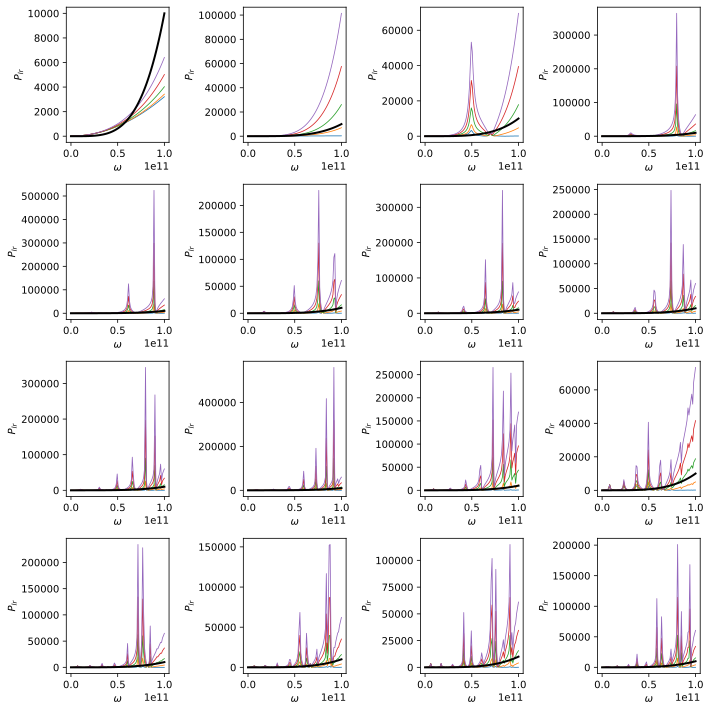

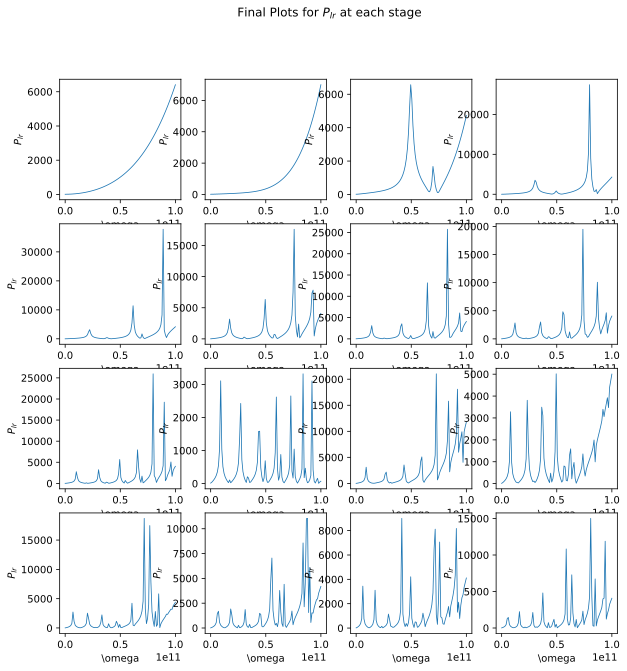

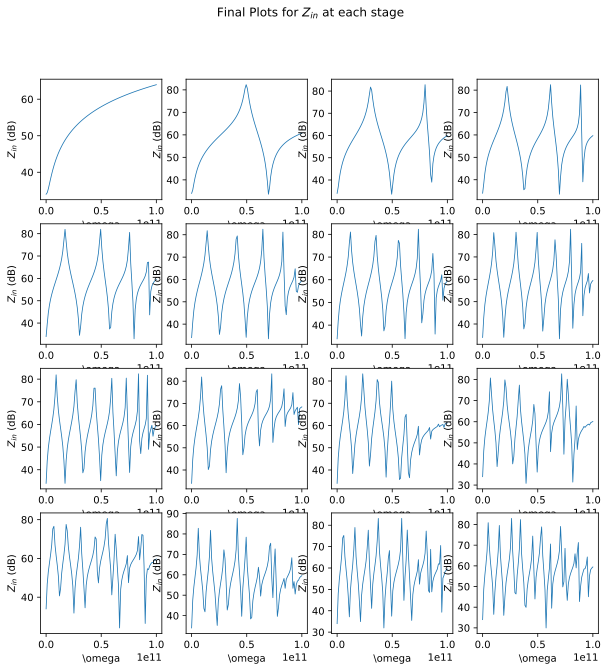

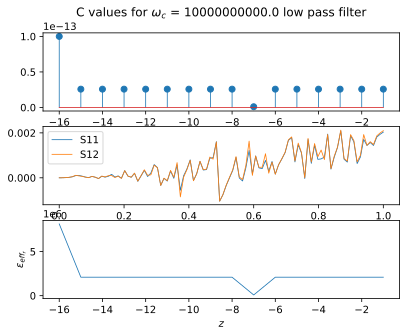

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants


# ----------- Actual Line fixed parameters ------------
c = 3e8
epsilon0 = constants.epsilon_0
wc = (10)*1e9
R0 = 50

N = 16

L0 = 8e-9 # [H/m] From KiCAD

# ----------- Line parameters for prototype low pass filter --------------

#L = L0*wc/R0
L = L0
Rs = R0
RL = R0

# ----------- Test Matrices for w and C ----------

wstart = 10e4
wstop = 100e9
wpoints = 100
w = np.linspace(wstart, wstop, wpoints)

Cstart = 1e-15
Cstop = 1e-13
Cpoints = 5

C = np.linspace(Cstart, Cstop, Cpoints)

# --------- Storage Matrices -----------------

C_sel = np.zeros((N, 2))
Zin_sel = np.zeros((N, len(w)), dtype=np.complex256)
Plr_sel = np.zeros((N, len(w)), dtype=np.complex256)
S11 = np.zeros((len(w),), dtype=np.complex256)
S12 = S11
zpoints = N*8
e_eff = np.zeros((N,))

# ----------- Comparison matrix -------------
Plr_req = 1 + (w/wc) ** 4

# ----------- Helpers ------------

def calculate_Zin_curr(L, w, C, Zin_prev):
    return 2*1j*L*w + Zin_prev*( (1-1j*np.outer(C, w*Zin_prev)) / (1 + np.outer(C**2, w**2 * Zin_prev**2)) )

def calculate_Plr(w, L, C, Zin_prev):
    return 1 + (1 / (4 * Zin_prev)) * (
                (1 - Zin_prev) ** 2 + ( (Zin_prev**2 * (C**2).reshape(-1, 1)) + L**2 - 2*L* (Zin_prev * C.reshape(-1, 1))) * w**2 + (
                    4 * L ** 2 * (Zin_prev**2 * (C**2).reshape(-1, 1)) ) * w**4)

def select_best_C(Plr, Plr_req):
    diff = np.abs(np.abs(Plr)-Plr_req)
    row_means = np.mean(diff, axis=1)
    min_mean_row_number = np.argmin(row_means)
    #print(row_means)
    return min_mean_row_number, min(row_means)

def plot_plr_for_different_Cs(Plr, Plr_req, w, C, i, gridSize, ax):
    rows = len(Plr[:, 0])
    legend_str = []  # Create an empty list to store legend entries
    #ax.set_title(f'$P_{{lr}}$ - Iteration {i+1}')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel("$P_{lr}$")
    for j in range(rows):
        ax.plot(w, (abs(Plr[j, :])))
    for j in range(rows):
        legend_str.append(str(C[j]))
    ax.plot(w, (Plr_req),  '-', linewidth=2, color='black')
    #ax.legend(legend_str)

def plot_final_Plrs(Plr_sel, w, ax):
    rows = len(Plr_sel[:, 0])
    for j in range(rows):
        ax.flat[j].plot(w, abs(Plr_sel[j, :]))
        ax.flat[j].set_xlabel("\omega")
        ax.flat[j].set_ylabel("$P_{lr}$")
    
def plot_Zin_sel(Zin_sel, w, ax):
    rows = len(Plr_sel[:, 0])
    for j in range(rows):
        ax.flat[j].plot(w, 20*np.log10(abs(Zin_sel[j, :])))
        ax.flat[j].set_xlabel("\omega")
        ax.flat[j].set_ylabel("$Z_{in}$ (dB)")

# ---------- S parameters ---------------

def find_section_params(L_curr, C_curr, w):
    gamma = np.sqrt((1j*w*L_curr) * (1j*w*C_curr))
    Zc = np.sqrt(L_curr/C_curr)
    return gamma, Zc

def find_S_params(gamma, Zc, w, ZL):
    Gamma = (Zc-ZL)/(Zc+ZL)
    l = 3e-6
    X = np.exp(-gamma*l)

    S11 = ((1-X**2)/(1-X**2 * Gamma**2))*Gamma
    #S22 = S11
    S12 = ((1-Gamma**2)/(1-X**2 * Gamma**2))*X
    #S21 = S12
    return S11, S12
    


# ----------- Start iterations ------------

Zin_prev = RL*np.ones(wpoints)
# Create a square grid of subplots
gridSize = int(np.ceil(np.sqrt(N)))

fig_Plrs, axes = plt.subplots(gridSize, gridSize, figsize=(10, 10))

for i in range(0, N):
    Zin_curr = calculate_Zin_curr(L, w, C, Zin_prev)
    Plr = calculate_Plr(w, L, C, Zin_prev)

    plot_plr_for_different_Cs(Plr, Plr_req, w, C, i, gridSize, axes.flat[i])

    optimal_row, error = select_best_C(Plr, Plr_req)
    
    C_sel[i] = (C[optimal_row], error)
    Zin_sel[i, : ] = Zin_curr[optimal_row, : ]
    Plr_sel[i, : ] = Plr[optimal_row, : ]

    # --- S params ----
    gamma, Zc = find_section_params(L, C_sel[i][0], w)
    if (i == 0):
        S11, S12 = find_S_params(gamma, Zc, w, ZL=Zin_prev)
    else:
        S11_new, S12_new = find_S_params(gamma, Zc, w, ZL=Zin_prev)
        S11 = S11_new*S11 + S12_new*S12
        S12 = S11_new*S12 + S12_new*S11

    # -- e_eff ---
    e_eff[i] = c**2 * L * C_sel[i][0]

    Zin_prev = Zin_curr[optimal_row, : ]

# Hide any remaining empty subplots
for i in range(N, gridSize*gridSize):
    axes.flat[i].axis('off')

plt.tight_layout()

fig_Plrs_final, axes_final = plt.subplots(gridSize, gridSize, figsize=(10, 10))
plot_final_Plrs(Plr_sel, w, axes_final)
fig_Plrs_final.suptitle("Final Plots for $P_{lr}$ at each stage")


fig_Zin_sel, axes_Zin_sel = plt.subplots(gridSize, gridSize, figsize=(10, 10))
plot_Zin_sel(Zin_sel, w, axes_Zin_sel)
fig_Zin_sel.suptitle("Final Plots for $Z_{in}$ at each stage")

plt.figure()
plt.subplot(3, 1, 1)
plt.stem(np.arange(N)-N, C_sel[:, 0])
plt.title(f"C values for $\omega_c$ = {wc} low pass filter")

plt.subplot(3, 1, 2)
plt.plot(w, 20*np.log10(abs(S11)))
plt.plot(w, 20*np.log10(abs(S12)))
plt.legend(["S11", "S12"])

plt.subplot(3, 1, 3)
plt.plot(np.arange(N)-N, e_eff/epsilon0)
plt.ylabel("$\epsilon_{eff_r}$")
plt.xlabel("$z$")

'''
X, Y = np.meshgrid(w, np.arange(N)*(3e-6/8))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with 'viridis' colormap
ax.plot_surface(X, Y, e_eff, cmap='plasma')

# Set labels and title
ax.set_xlabel('w')
ax.set_ylabel('z')
ax.set_zlabel('e_eff')
ax.set_title('$\epsilon(w, z)$')

# Set the color of the axes to white
ax.xaxis.pane.set_color('white')
ax.yaxis.pane.set_color('white')
ax.zaxis.pane.set_color('white')

# Show the plot
plt.show()

# Create dataframes from the arrays
df_C_sel = pd.DataFrame(C_sel, columns=['C_optimal', 'Error'])
df_Plr_sel = pd.DataFrame(Plr_sel, columns=w)
df_Zin_sel = pd.DataFrame(Zin_sel, columns=w)
df_e_eff = pd.DataFrame(e_eff, columns=w)

# Save dataframes to a CSV file
df_C_sel.to_csv('C_sel.csv', index=False)
df_Plr_sel.to_csv('Plr_sel.csv', index=False)
df_Zin_sel.to_csv('Zin_sel.csv', index=False)
df_e_eff.to_csv('e_eff.csv', index=False)'''

plt.show()


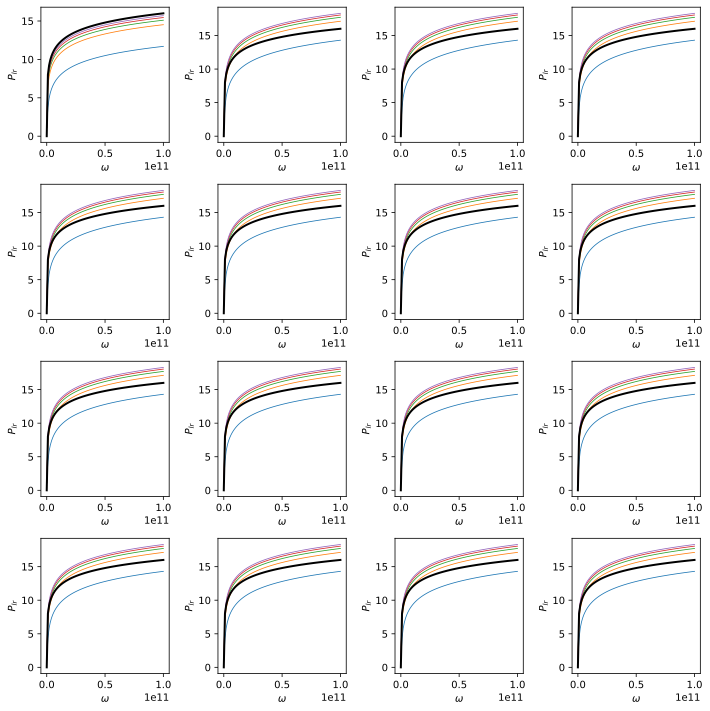

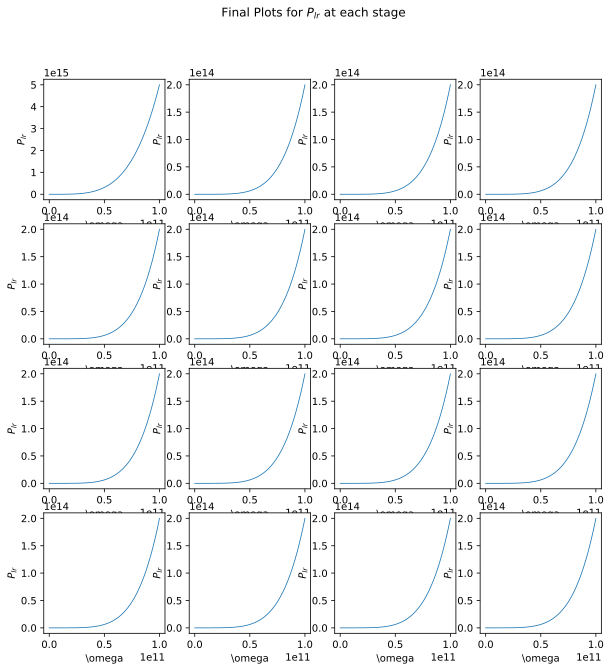

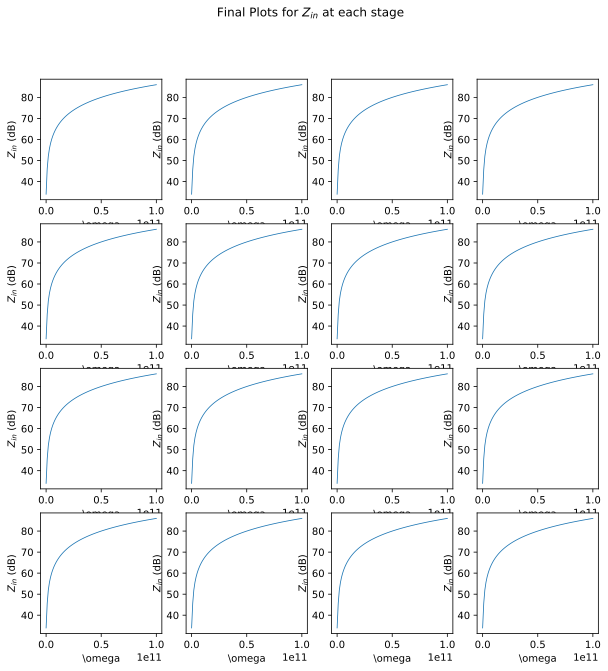

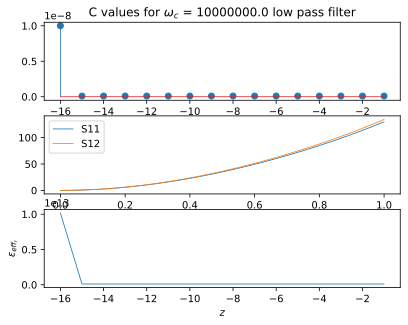

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants


# ----------- Actual Line fixed parameters ------------
c = 3e8
epsilon0 = constants.epsilon_0
wc = (1e-2)*1e9
R0 = 50

N = 16

L0 = 1e-7 # [H/m] From KiCAD

# ----------- Line parameters for prototype low pass filter --------------

#L = L0*wc/R0
L = L0
Rs = R0
RL = R0

# ----------- Test Matrices for w and C ----------

wstart = 10e4
wstop = 100e9
wpoints = 100
w = np.linspace(wstart, wstop, wpoints)

# values from KiCAD
Cstart = 1e-9
Cstop = 1e-8
Cpoints = 5

C = np.linspace(Cstart, Cstop, Cpoints)

# --------- Storage Matrices -----------------

C_sel = np.zeros((N, 2))
Zin_sel = np.zeros((N, len(w)), dtype=np.complex256)
Plr_sel = np.zeros((N, len(w)), dtype=np.complex256)
S11 = np.zeros((len(w),), dtype=np.complex256)
S12 = S11
zpoints = N*8
e_eff = np.zeros((N,))

# ----------- Comparison matrix -------------
Plr_req = 1 + (w/wc) ** 4

# ----------- Helpers ------------

def calculate_Zin_curr(L, w, C, Zin_prev):
    return 2*1j*L*w + Zin_prev*( (1-1j*np.outer(C, w*Zin_prev)) / (1 + np.outer(C**2, w**2 * Zin_prev**2)) )

def calculate_Plr(w, L, C, Zin_prev):
    return 1 + (1 / (4 * Zin_prev)) * (
                (1 - Zin_prev) ** 2 + ( (Zin_prev**2 * (C**2).reshape(-1, 1)) + L**2 - 2*L* (Zin_prev * C.reshape(-1, 1))) * w**2 + (
                    4 * L ** 2 * (Zin_prev**2 * (C**2).reshape(-1, 1)) ) * w**4)

def select_best_C(Plr, Plr_req):
    diff = np.abs(np.abs(Plr)-Plr_req)
    row_means = np.mean(diff, axis=1)
    min_mean_row_number = np.argmin(row_means)
    #print(row_means)
    return min_mean_row_number, min(row_means)

def plot_plr_for_different_Cs(Plr, Plr_req, w, C, i, gridSize, ax):
    rows = len(Plr[:, 0])
    legend_str = []  # Create an empty list to store legend entries
    #ax.set_title(f'$P_{{lr}}$ - Iteration {i+1}')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel("$P_{lr}$")
    for j in range(rows):
        ax.plot(w, np.log10(abs(Plr[j, :])))
    for j in range(rows):
        legend_str.append(str(C[j]))
    ax.plot(w, np.log10(Plr_req),  '-', linewidth=2, color='black')
    #ax.legend(legend_str)

def plot_final_Plrs(Plr_sel, w, ax):
    rows = len(Plr_sel[:, 0])
    for j in range(rows):
        ax.flat[j].plot(w, abs(Plr_sel[j, :]))
        ax.flat[j].set_xlabel("\omega")
        ax.flat[j].set_ylabel("$P_{lr}$")
    
def plot_Zin_sel(Zin_sel, w, ax):
    rows = len(Plr_sel[:, 0])
    for j in range(rows):
        ax.flat[j].plot(w, 20*np.log10(abs(Zin_sel[j, :])))
        ax.flat[j].set_xlabel("\omega")
        ax.flat[j].set_ylabel("$Z_{in}$ (dB)")

# ---------- S parameters ---------------

def find_section_params(L_curr, C_curr, w):
    gamma = np.sqrt((1j*w*L_curr) * (1j*w*C_curr))
    Zc = np.sqrt(L_curr/C_curr)
    return gamma, Zc

def find_S_params(gamma, Zc, w, ZL):
    Gamma = (Zc-ZL)/(Zc+ZL)
    l = 3e-6
    X = np.exp(-gamma*l)

    S11 = ((1-X**2)/(1-X**2 * Gamma**2))*Gamma
    #S22 = S11
    S12 = ((1-Gamma**2)/(1-X**2 * Gamma**2))*X
    #S21 = S12
    return S11, S12
    


# ----------- Start iterations ------------

Zin_prev = RL*np.ones(wpoints)
# Create a square grid of subplots
gridSize = int(np.ceil(np.sqrt(N)))

fig_Plrs, axes = plt.subplots(gridSize, gridSize, figsize=(10, 10))

for i in range(0, N):
    Zin_curr = calculate_Zin_curr(L, w, C, Zin_prev)
    Plr = calculate_Plr(w, L, C, Zin_prev)

    plot_plr_for_different_Cs(Plr, Plr_req, w, C, i, gridSize, axes.flat[i])

    optimal_row, error = select_best_C(Plr, Plr_req)
    
    C_sel[i] = (C[optimal_row], error)
    Zin_sel[i, : ] = Zin_curr[optimal_row, : ]
    Plr_sel[i, : ] = Plr[optimal_row, : ]

    # --- S params ----
    gamma, Zc = find_section_params(L, C_sel[i][0], w)
    if (i == 0):
        S11, S12 = find_S_params(gamma, Zc, w, ZL=Zin_prev)
    else:
        S11_new, S12_new = find_S_params(gamma, Zc, w, ZL=Zin_prev)
        S11 = S11_new*S11 + S12_new*S12
        S12 = S11_new*S12 + S12_new*S11

    # -- e_eff ---
    e_eff[i] = c**2 * L * C_sel[i][0]

    Zin_prev = Zin_curr[optimal_row, : ]

# Hide any remaining empty subplots
for i in range(N, gridSize*gridSize):
    axes.flat[i].axis('off')

plt.tight_layout()

fig_Plrs_final, axes_final = plt.subplots(gridSize, gridSize, figsize=(10, 10))
plot_final_Plrs(Plr_sel, w, axes_final)
fig_Plrs_final.suptitle("Final Plots for $P_{lr}$ at each stage")


fig_Zin_sel, axes_Zin_sel = plt.subplots(gridSize, gridSize, figsize=(10, 10))
plot_Zin_sel(Zin_sel, w, axes_Zin_sel)
fig_Zin_sel.suptitle("Final Plots for $Z_{in}$ at each stage")

plt.figure()
plt.subplot(3, 1, 1)
plt.stem(np.arange(N)-N, C_sel[:, 0])
plt.title(f"C values for $\omega_c$ = {wc} low pass filter")

plt.subplot(3, 1, 2)
plt.plot(w, 20*np.log10(abs(S11)))
plt.plot(w, 20*np.log10(abs(S12)))
plt.legend(["S11", "S12"])

plt.subplot(3, 1, 3)
plt.plot(np.arange(N)-N, e_eff/epsilon0)
plt.ylabel("$\epsilon_{eff_r}$")
plt.xlabel("$z$")

'''
X, Y = np.meshgrid(w, np.arange(N)*(3e-6/8))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with 'viridis' colormap
ax.plot_surface(X, Y, e_eff, cmap='plasma')

# Set labels and title
ax.set_xlabel('w')
ax.set_ylabel('z')
ax.set_zlabel('e_eff')
ax.set_title('$\epsilon(w, z)$')

# Set the color of the axes to white
ax.xaxis.pane.set_color('white')
ax.yaxis.pane.set_color('white')
ax.zaxis.pane.set_color('white')

# Show the plot
plt.show()

# Create dataframes from the arrays
df_C_sel = pd.DataFrame(C_sel, columns=['C_optimal', 'Error'])
df_Plr_sel = pd.DataFrame(Plr_sel, columns=w)
df_Zin_sel = pd.DataFrame(Zin_sel, columns=w)
df_e_eff = pd.DataFrame(e_eff, columns=w)

# Save dataframes to a CSV file
df_C_sel.to_csv('C_sel.csv', index=False)
df_Plr_sel.to_csv('Plr_sel.csv', index=False)
df_Zin_sel.to_csv('Zin_sel.csv', index=False)
df_e_eff.to_csv('e_eff.csv', index=False)'''

plt.show()
